# Illustrating UMAP

All data is publicly available at:
* http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/hd_genotype_chip/
* http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/

We will use the following files:
* `ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz`
* `affy_samples.20141118.panel`
* `20131219.populations.tsv`

In [2]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
import itertools
import numba
import numpy as np
import os
import time

# Import colour palettes for later on
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
import umap
import umap.plot

In [3]:
umap.__version__

'0.4.0rc1'

In [4]:
# Specify your parent directory. This is where your 1KGP files are stored
data_dir = '../../1KGP_dimred/data'

# These are the names of the files we use
vcf_name = 'ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz'
pop_desc_name = '20131219.populations.tsv'
pop_file_name = 'affy_samples.20141118.panel'

vcf_file = os.path.join(data_dir, vcf_name)
population_description_file = os.path.join(data_dir, pop_desc_name)
population_file = os.path.join(data_dir, pop_file_name)

In [5]:
# Code to read in the SNP data. Assign every SNP a value of {0,1,2} relative to reference genome.
from collections import Counter

class snp(object):

    def __init__(self, line, select=False, autosome_only =True):
        """The initialization method takes in a line from the vcf file, as a string, 
        and records the relevant information. 
        line: a string from a vcf file
        select: a list of positions of individuals to be analyzed, where positions run from 0 to 
        nInd-1, the number of individuals
        """ 
        
        split_line = line.split()  #  First break down the line into a list of each field
        
        self.failed = False  # A label that we will set to True if something goes wrong.
        
        if line.startswith('#'):
            self.failed = True
            self.failure_cause = "line was a header line, not a snp"
            return
        
        if len(split_line)<=5:
            self.failed = True
            self.failure_cause = "incorrectly formatted line, should have at least 5 fields " + line
            return
          
        self.chrom = split_line[0]
        if autosome_only:
            if self.chrom not in ["%d" % (i,) for i in range(1,23)]:
                self.failed = True
                self.failure_cause = "not recognized as an autosome while autosome_only set to True"
                return
        
        self.chrom = int(split_line[0]) # Chromosome (numbered)
        self.position = int(split_line[1])  # The coordinates of the snp
        self.rid = split_line[2] # Name/Record ID
        self.ref_allele = split_line[3]
        self.alt_allele = split_line[4] # The alterate allele according to the vcf; also a string 
        # Only accept snps in ACGT. 
        if self.ref_allele not in ["A","C","G","T"] or self.alt_allele not in ["A","C","G","T"]:
            self.failed = True
            self.failure_cause = "ref or alt not in ACGT"
            return
        self.filter = split_line[6]  # See vcf format specifications for the interpretation of 
                                    # the filter field
        if self.filter not in ['PASS', '.'] :  # PASS indicates a SNP that passed all QC filters.
            self.failed = True
            self.failure_cause = self.filter
            return
              
        self.genotype_strings = split_line[9:]

        # Prepare a list that will contain the transformed genotypes. 
        # Since we already know how long the list will be, it makes sense 
        # to create an array of zeros of the same length as self.gtypes, 
        
        self.genotype_array = np.zeros(len(self.genotype_strings), dtype = np.int8)             

        # Count the number of each genotype. 
        # There may be different strings giving the same genotype so we increment the 
        # counts found so far for the genotype by the number of times the  
        # For example, "0/0" and "0\0" give homref, and "0|1" and "1|0" give het
        
        n_missing = 0
        for index,genotype_string in enumerate(self.genotype_strings):
            if genotype_string == './.':
                n_missing +=1 
                self.genotype_array[index]=-1
                continue # missing data will be left as 0
            allele_0 = genotype_string[0] # Get the first allele (as a string)
            allele_1 = genotype_string[2]
            if (allele_0=='1' and allele_1=='1'): # Use rstrip because windows machines will occasionally have extra \n
                self.genotype_array[index]=2
            elif ((allele_0=='0' and allele_1=='1') or (allele_0=='1' and allele_1=='0')):
                self.genotype_array[index]=1   
            elif (allele_0=='0' and allele_1=='0'):
                # The array was initialized to zero, so nothing to do here!
                continue
            else:
                print(("unknown genotype", genotype_string))
                self.failed=True
                self.failedreason="unknown genotype"
                return

The following step imports the genotype data. It is not particularly efficient so will take a few minutes even if we skip some of the lines.

In [6]:
# Specify the number of lines to skip to avoid storing every line in memory
number_of_lines_to_skip = 10

start_time = time.time()

genotype_matrix = []  # Will contain our numerical genotype matrix. 
genotype_positions = []
genotype_names = []
x = 0
error_count = 0

with gzip.open(vcf_file,'rt') as f:
    count = 0
    for line in f:
        count+=1
        if count % number_of_lines_to_skip == 0:
            if line.startswith("#") or snp(line).failed:
                if snp(line).failure_cause != "line was a header line, not a snp":
                    error_count += 1
                    if x < 10:
                        print('Failed: ' + snp(line).failure_cause)
                        x+=1
                continue
            
            return_snp = snp(line)
            genotype_matrix.append(return_snp.genotype_array)
            genotype_names.append(return_snp.rid)
            genotype_positions.append([return_snp.chrom, return_snp.position])

end_time = time.time()
            
print("Run time in seconds: " + str(end_time - start_time))

Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Run time in seconds: 283.43451404571533


In [7]:
# Transpose the matrix
transposed_genotype_matrix = np.array(genotype_matrix).transpose()

The following code imports auxiliary data (population, continent, descriptive data, colouring, etc.)

In [8]:
population_by_individual = defaultdict(int)
individuals_by_population = defaultdict(list)  # A dictionary containing all the individuals in a given population

for line in open(population_file,'r'):
    split_line = line.split()
    if split_line[0] == 'sample':  # header line
        continue

    sample_name = split_line[0]
    population_name = split_line[1]
    population_by_individual[sample_name] = population_name
    individuals_by_population[population_name].append(sample_name) 

populations = list(individuals_by_population.keys())

In [9]:
# The path to the place where you put the population name file.
name_by_code = {}  # A dictionary giving the full name of each population code
pop_by_continent = {}  # A dictionary giving the code of each population within a continent  
continent_by_population = {}  # A dictionary giving the continent for each population code
for line in open(population_description_file,'r'):
    split_line = line.split('\t')
    if split_line[0] in ['Population Description','Total','']:  # header or footer
        continue
    name_by_code[split_line[1]] = split_line[0]
    continent_by_population[split_line[1]] = split_line[2]
    try: 
        pop_by_continent[split_line[2]].append(split_line[1])
    except KeyError:
        pop_by_continent[split_line[2]] = [split_line[1]]

continents = list(pop_by_continent.keys()) 
    
    
# Populations listed by continent
pops=[]
for continent in continents:
    pops.extend(pop_by_continent[continent])

In [10]:
# Assign colours to each population, roughly themed according to continent
# The Category20b palette has a bunch of groups of 4 shades in the same colour range
color_dict = {}
for i, cont in enumerate(continents): 
    for j, pop in enumerate(pop_by_continent[cont]):
        color_dict[pop] = Category20b[20][4*i+j%4]

# Colour palette above only really supports groups of 4 so we have to manually specify a few colours for the 5th/6th
# members of a group

color_dict['CHS'] = Purples[9][4]# purple
color_dict['STU'] = Greens[9][6] # green
color_dict['LWK'] = PuOr[11][-1] # brown
color_dict['MSL'] = PuOr[11][-2] # rusty brown
color_dict['YRI'] = PuOr[11][-3] # cappucino w/ extra milk (stirred)
color_dict['CEU'] = RdGy[11][-3]

In [11]:
for line in gzip.open(vcf_file,'rt'):
    if line.startswith("#"):
        if not line.startswith("##"):
            # Extract the individuals for the population, as a list of strings
            # Windows users may have trailing \n characters
            individuals = line.split()[9:]
            # Once we've extracted the individuals, we can exit the loops. 
            break

# Build a list of populations for each indiviudal in the vcf file
lspop = []
for ind in individuals:
    pop = population_by_individual[ind]
    if pop == 0:
        lspop.append("missing")
    else:
        lspop.append(pop)

        
indices_of_population_members = defaultdict(list)

for index,individual in enumerate(individuals):
    try:
        indices_of_population_members[population_by_individual[individual]].append(index)
    except KeyError: # We do not have population info for this individual
        continue

In [12]:
count = 0

for p in pop_by_continent:
    count+=len(pop_by_continent[p])
    
print(count)

26


In [13]:
imax = 0
imin = 200
for i in indices_of_population_members:
    imax = max(len(indices_of_population_members[i]),imax)
    imin = min(len(indices_of_population_members[i]),imin)
    
print(imax, imin)

183 104


# Dimension reduction

In [14]:
# Project onto the PC axes
#pca_full = PCA().fit(transposed_genotype_matrix)
#proj_pca = pca_full.fit_transform(transposed_genotype_matrix)

#np.savetxt(X=proj_pca, fname='pca_full.txt')

proj_pca = np.loadtxt("../../1KGP_dimred/pca_full.txt.gz")

In [15]:
proj_pca.shape

(3450, 3450)

### PCA-UMAP: Low NN

Run UMAP on the top PCs using 15 neighbours.

In [ ]:
mapper_pca_umap = umap.UMAP(n_neighbors=15, min_dist=0.5).fit(proj_pca[:,:25])

In [24]:
# Save the embedding
# np.savetxt("umap_pc25_nn15_md05.txt.gz", mapper_pca_umap.embedding_)

Text(0, 0.5, 'UMAP2')

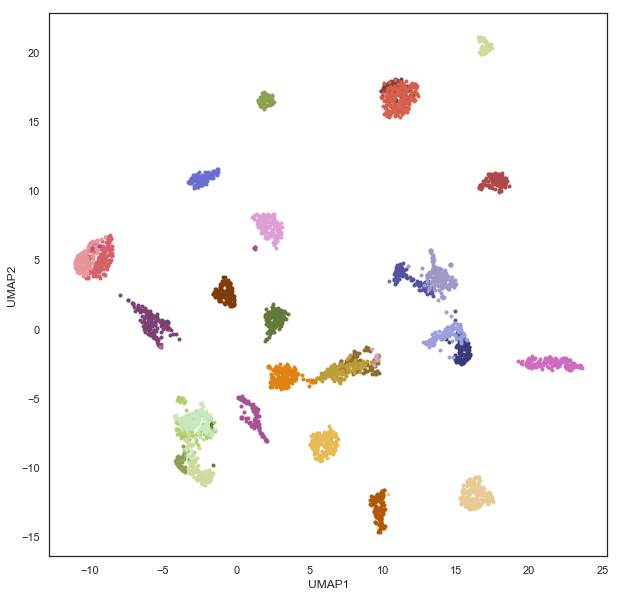

In [25]:
plt.figure(figsize=(10,10))
# Use the PCA projection
dset = mapper_pca_umap.embedding_

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop])

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

### PCA-UMAP: High NN

In [65]:
mapper_pca_umap = umap.UMAP(n_neighbors=200, min_dist=0.5).fit(proj_pca[:,:25])

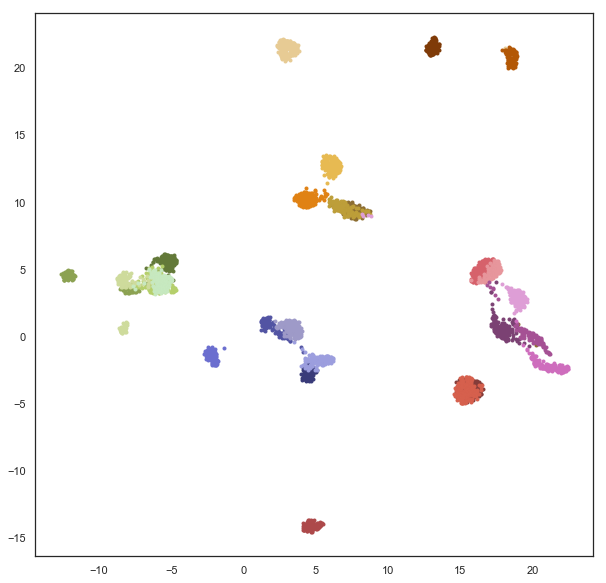

In [67]:
plt.figure(figsize=(10,10))
# Use the PCA projection
dset = mapper_pca_umap.embedding_

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop])

### PCA: Even higher NN

In [68]:
mapper_pca_umap = umap.UMAP(n_neighbors=500, min_dist=0.5).fit(proj_pca[:,:25])

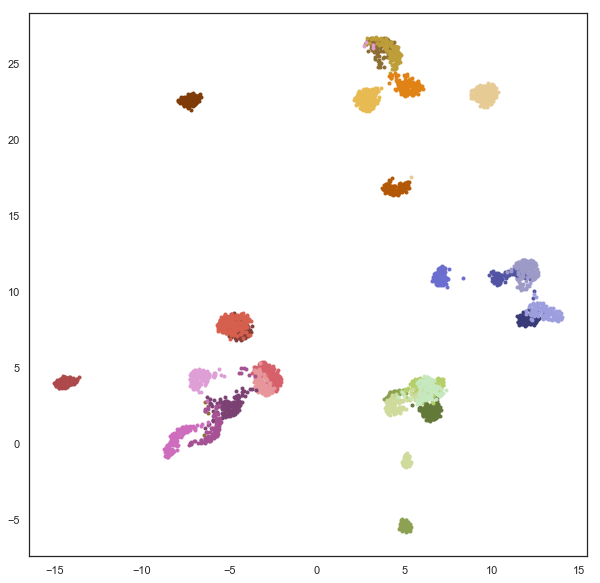

In [69]:
plt.figure(figsize=(10,10))
# Use the PCA projection
dset = mapper_pca_umap.embedding_

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop])

### PCA: Higher NN, more PCs

In [72]:
mapper_pca_umap = umap.UMAP(n_neighbors=500, min_dist=0.5).fit(proj_pca[:,:100])

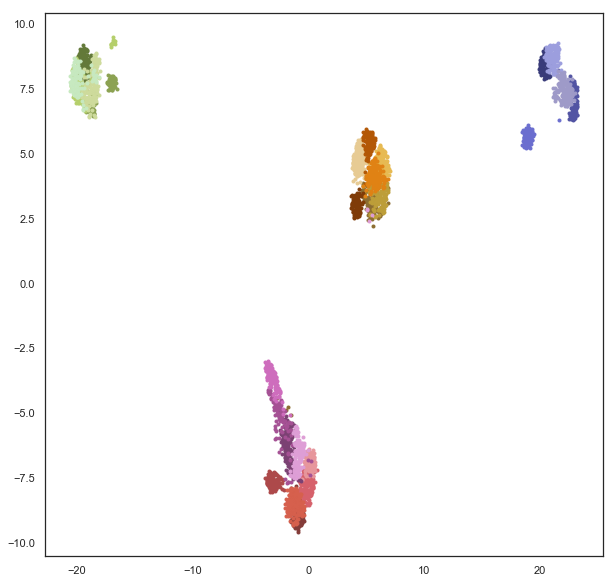

In [73]:
plt.figure(figsize=(10,10))
# Use the PCA projection
dset = mapper_pca_umap.embedding_

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop])

### Genotype: Low NN

In [164]:
mapper_gt_umap_lownn = umap.UMAP(n_neighbors=15, min_dist=0.5).fit(transposed_genotype_matrix)

In [165]:
# Save the embedding
np.savetxt("umap_gt_nn15_md05.txt.gz", mapper_gt_umap_lownn.embedding_)

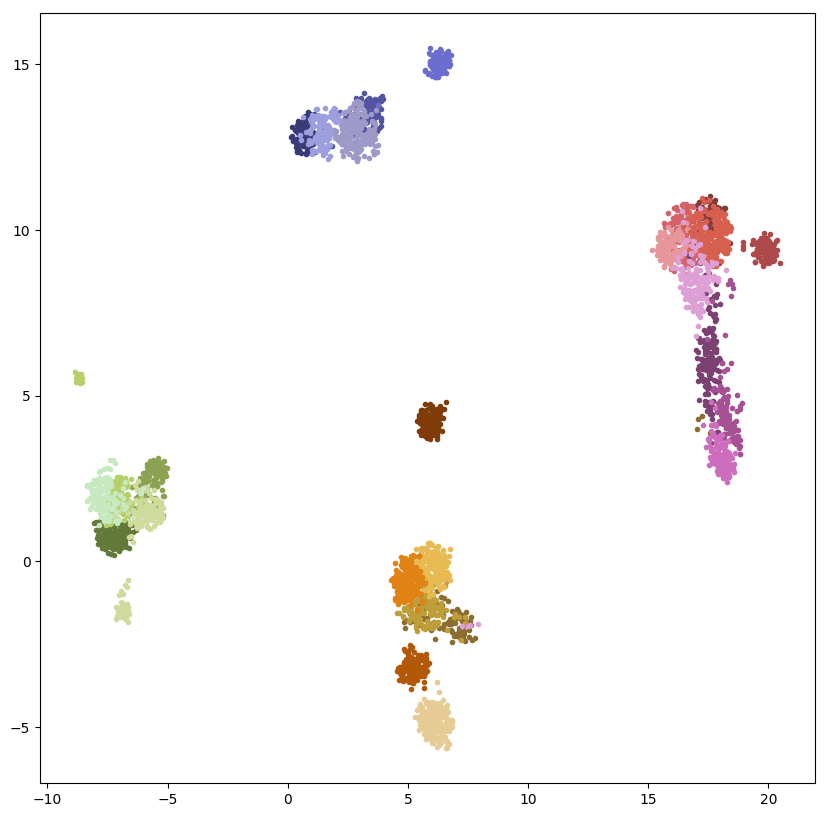

In [166]:
plt.figure(figsize=(10,10))
# Use the PCA projection
dset = mapper_gt_umap_lownn.embedding_

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop])

In [178]:
?umap.plot.connectivity

In [198]:
?mapper_gt_umap.graph_

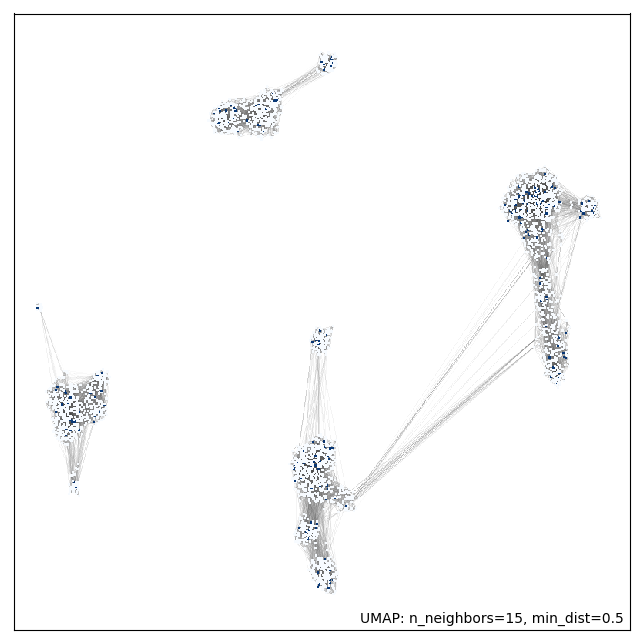

In [188]:
import warnings; warnings.simplefilter('ignore')
umap.plot.connectivity(mapper_gt_umap_lownn, show_points=True)
plt.savefig("images/UMAP_connectivity_low_NN.png", dpi = 300)

In [ ]:
start = time.time()
umap.plot.connectivity(mapper_gt_umap_lownn, edge_bundling='hammer')
end = time.time()

print(end - start)

### Genotype: High NN

In [158]:
mapper_gt_umap_highnn = umap.UMAP(n_neighbors=200, min_dist=0.5).fit(transposed_genotype_matrix)

In [162]:
#np.savetxt("umap_gt_nn200_md05.txt.gz", mapper_gt_umap_highnn.embedding_)

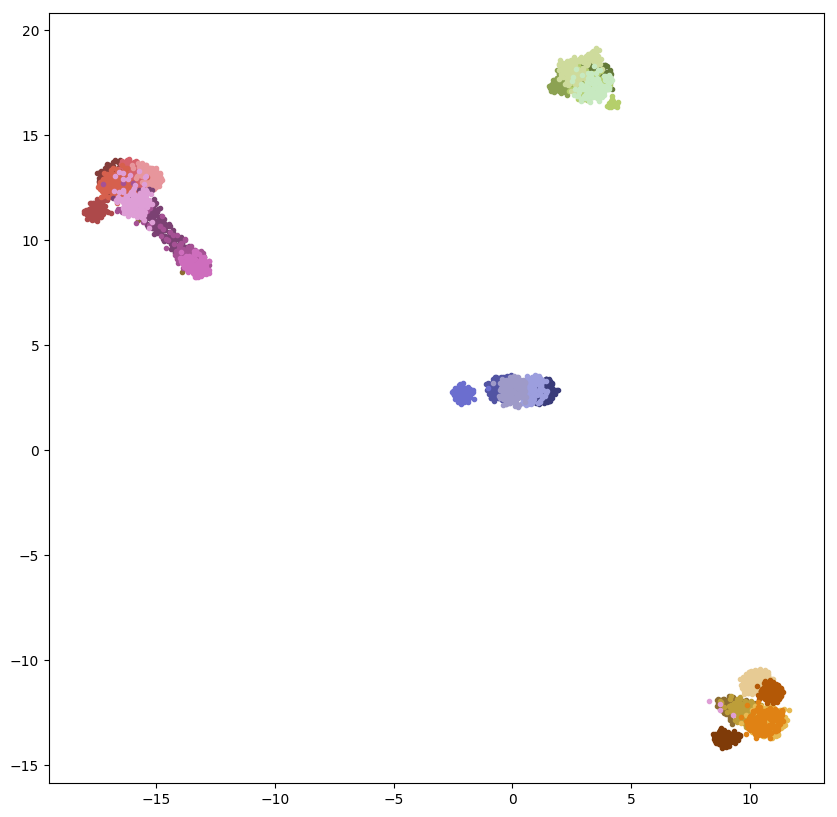

In [160]:
plt.figure(figsize=(10,10))
# Use the PCA projection
dset = mapper_gt_umap_highnn.embedding_

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop])

In [186]:
?umap.plot.connectivity

In [192]:
?umap.plot.connectivity

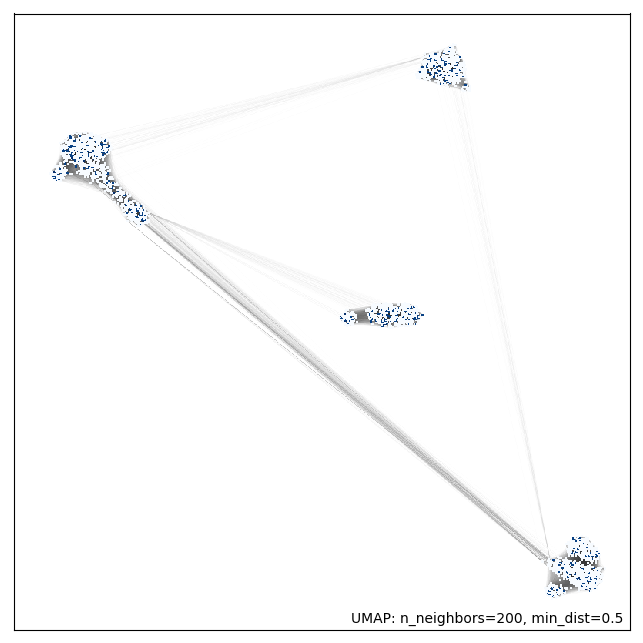

In [190]:
# more neighbours makes for more edge weights
umap.plot.connectivity(mapper_gt_umap_highnn, show_points=True)
plt.savefig("images/UMAP_connectivity_high_NN.png", dpi = 300)

In [ ]:
start = time.time()
umap.plot.connectivity(mapper_gt_umap_highnn, edge_bundling='hammer')
end = time.time()

print(end - start)

### Images for review
Images to illustrate UMAP. Most of the populations form single clusters. Those that are split have a little extra code to manually label them (otherwise only one of the clusters gets a label).

In [16]:
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

In [25]:
# parameters for plots
point_alpha = 0.15 # alpha parameter for points
fsize = 20 # font size for labels
lwidth = 0.5 # line width for labels

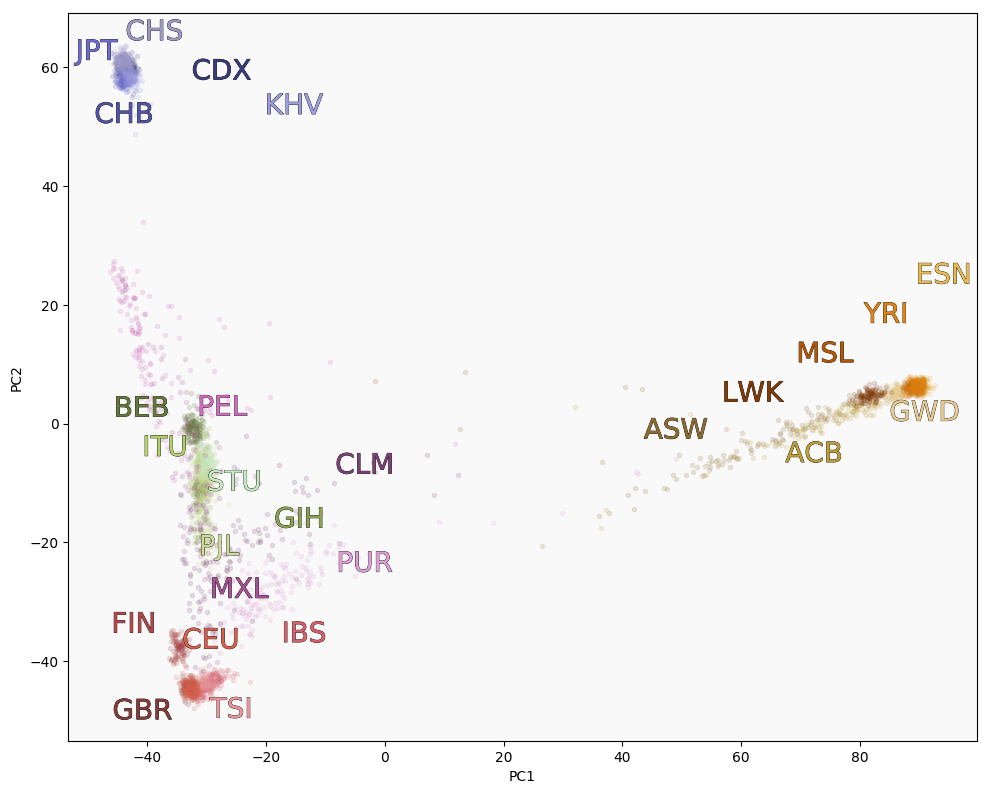

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect=1)

ax.set_facecolor('#f9f9f9')

dset = proj_pca

texts = []

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop], alpha=point_alpha)
        
        for i, temp_proj_sub in enumerate(temp_proj):
            if i==temp_proj.shape[0]-1:
                texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                     fontdict={"color": color_dict[pop], "size": fsize},
                                     path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))

adjust_text(texts)

plt.style.use(['default'])
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.savefig("images/1KGP_PCA.png", dpi = 300)#, bbox_inches = 'tight')

NameError: name 'mapper_pca_umap' is not defined

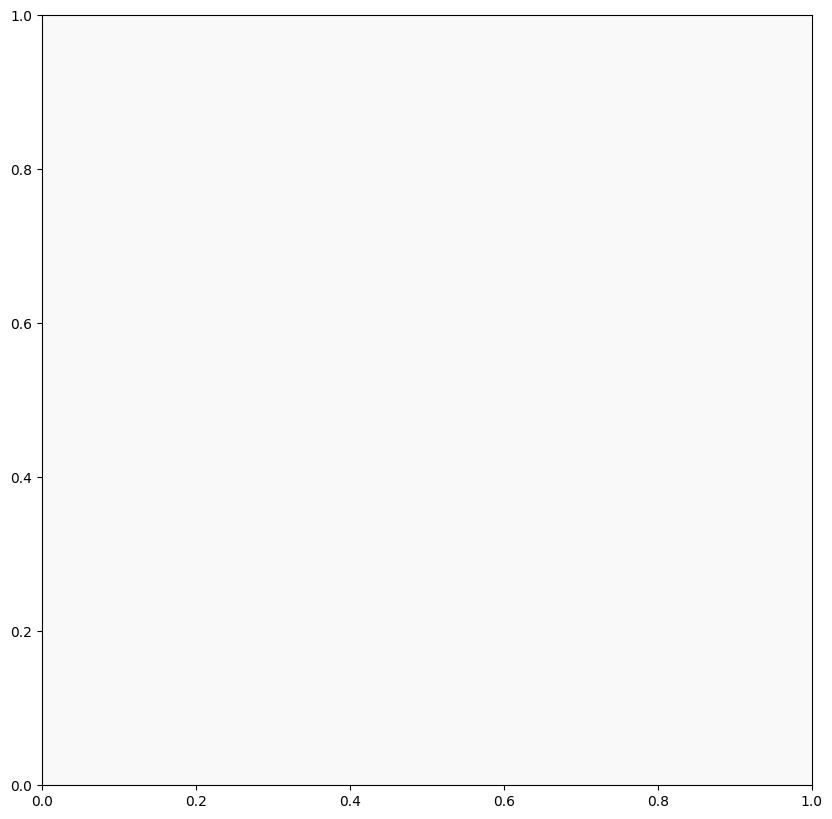

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect=1)

ax.set_facecolor('#f9f9f9')

dset = mapper_pca_umap.embedding_

fsize = 15
texts = []

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop], alpha=point_alpha)
        
        for i, temp_proj_sub in enumerate(temp_proj):
            if pop in ["GIH"]:
                if i==temp_proj.shape[0]-1 or i==0:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))
            elif pop=="PJL": #142
                if i in [0, 142]:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))
            else:
                if i==temp_proj.shape[0]-1:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))

adjust_text(texts)
plt.xlabel("PCA-UMAP1")
plt.ylabel("PCA-UMAP2")

plt.tight_layout()
plt.savefig("images/1KGP_PCA_UMAP.png", dpi = 300)#, bbox_inches = 'tight')

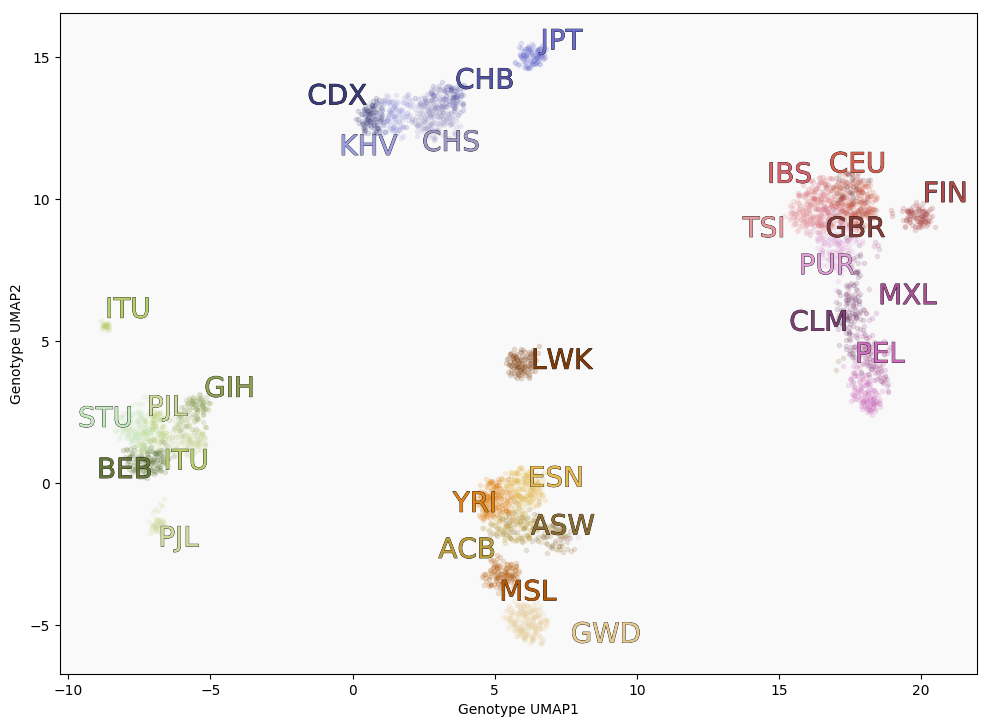

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect=1)

#dset = mapper_gt_umap.embedding_
dset = np.loadtxt("umap_gt_nn15_md05.txt.gz")

fsize = 20
texts = []

ax.set_facecolor('#f9f9f9')

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop], alpha=point_alpha)
        
        for i, temp_proj_sub in enumerate(temp_proj):
            if pop=="PJL": # points 0 and 142 fall into separate clusters
                if i in [0, 142]:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))
            elif pop=="ITU":
                if i in [0,33]:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))
            else:
                if i==temp_proj.shape[0]-1:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))

adjust_text(texts)
plt.xlabel("Genotype UMAP1")
plt.ylabel("Genotype UMAP2")

plt.tight_layout()
plt.savefig("images/1KGP_genotype_UMAP.png", dpi = 300)#, bbox_inches = 'tight')

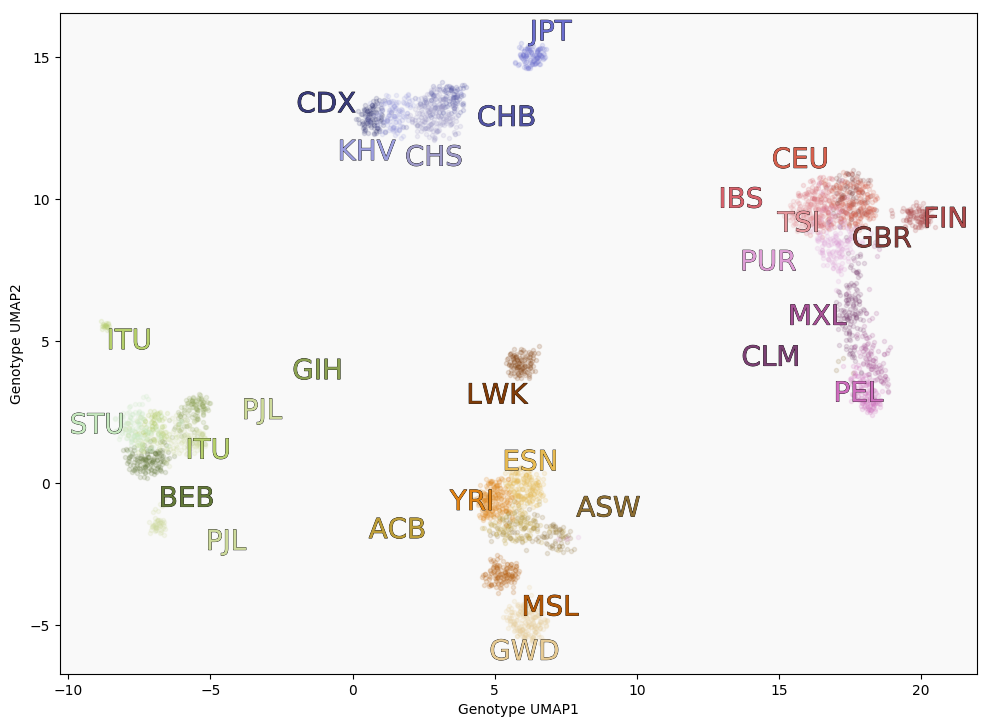

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect=1)

#dset = mapper_gt_umap.embedding_
dset = np.loadtxt("umap_gt_nn15_md05.txt.gz")

ax.set_facecolor('#f9f9f9')

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop], alpha=point_alpha)
        
        for i, temp_proj_sub in enumerate(temp_proj):
            if pop=="PJL": # points 0 and 142 fall into separate clusters
                if i in [0, 142]:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))
            elif pop=="ITU":
                if i in [0,33]:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))
            else:
                if i==temp_proj.shape[0]-1:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))

adjust_text(texts)
plt.xlabel("Genotype UMAP1")
plt.ylabel("Genotype UMAP2")

plt.tight_layout()
plt.savefig("images/1KGP_genotype_UMAP_low_NN.png", dpi = 300)#, bbox_inches = 'tight')

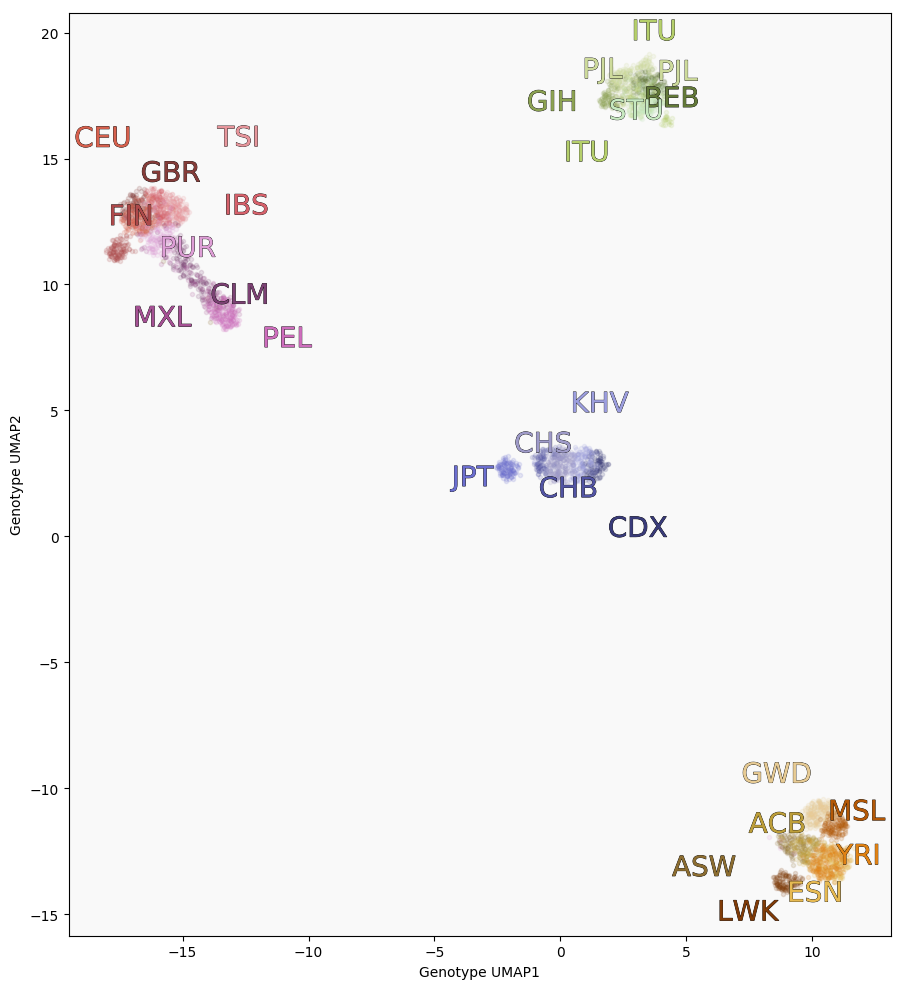

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect=1)

#dset = mapper_gt_umap.embedding_
dset = np.loadtxt("umap_gt_nn200_md05.txt.gz")

ax.set_facecolor('#f9f9f9')

for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = dset[indices_of_population_members[pop]]
        plt.plot(temp_proj[:,0], temp_proj[:,1], '.', color = color_dict[pop], alpha=point_alpha)
        
        for i, temp_proj_sub in enumerate(temp_proj):
            if pop=="PJL": # points 0 and 142 fall into separate clusters
                if i in [0, 142]:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))
            elif pop=="ITU":
                if i in [0,33]:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))
            else:
                if i==temp_proj.shape[0]-1:
                    texts.append(ax.text(temp_proj_sub[0], temp_proj_sub[1], pop,
                                         fontdict={"color": color_dict[pop], "size": fsize},
                                         path_effects=[PathEffects.withStroke(linewidth=lwidth, foreground="black")]))

adjust_text(texts)
plt.xlabel("Genotype UMAP1")
plt.ylabel("Genotype UMAP2")

plt.tight_layout()
plt.savefig("images/1KGP_genotype_UMAP_high_NN.png", dpi = 300)#, bbox_inches = 'tight')

In [191]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'numpy',
 'numba',
 'sklearn',
 'matplotlib.pyplot',
 'pandas',
 'seaborn',
 'umap',
 'collections',
 'gzip',
 'itertools',
 'os',
 'time',
 'bokeh',
 'math',
 'matplotlib.patheffects',
 'warnings',
 'types']